In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


In [5]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape


torch.Size([4, 3, 6, 6])

In [6]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [7]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))   

In [8]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk


In [9]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))


In [10]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


KeyboardInterrupt: 

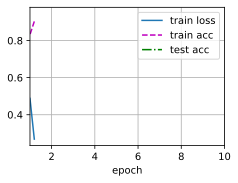

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

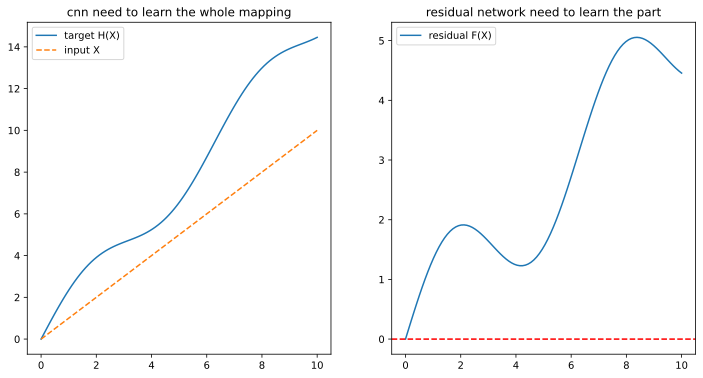

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 创建示例数据
x = np.linspace(0, 10, 100)
# 假设这是我们要学习的目标函数
target = 1.5 * x + np.sin(x)  # H(X)

# 计算残差（需要学习的部分）
residual = target - x  # F(X) = H(X) - X

# 可视化
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(x, target, label='target H(X)')
plt.plot(x, x, '--', label='input X')
plt.legend()
plt.title('cnn need to learn the whole mapping')

plt.subplot(122)
plt.plot(x, residual, label='residual F(X)')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.title('residual network need to learn the part')
plt.show()

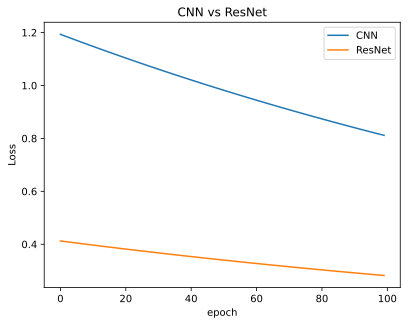

In [15]:
import torch
import torch.nn as nn

# 模拟一个简单的学习任务
class SimpleExample:
    def __init__(self):
        # 生成数据
        self.X = torch.randn(1000, 10)  # 输入数据
        # 假设目标函数接近于恒等映射
        self.Y = self.X + 0.1 * torch.randn(1000, 10)  # 目标=输入+小噪声
        
    def train_traditional(self):
        # 传统网络
        model = nn.Linear(10, 10)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
        losses = []
        for _ in range(100):
            pred = model(self.X)
            loss = ((pred - self.Y) ** 2).mean()
            losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return losses
    
    def train_residual(self):
        # 残差网络
        model = nn.Linear(10, 10)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
        losses = []
        for _ in range(100):
            # 只学习残差部分
            residual = model(self.X)
            pred = self.X + residual  # 残差连接
            loss = ((pred - self.Y) ** 2).mean()
            losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return losses

# 运行实验
example = SimpleExample()
traditional_losses = example.train_traditional()
residual_losses = example.train_residual()

# 绘制损失曲线
plt.plot(traditional_losses, label='CNN')
plt.plot(residual_losses, label='ResNet')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN vs ResNet')
plt.show()